In [1]:
# Import Helper Functions
source("sales_exploration_helpers.R")


In [37]:
library(dplyr)
library(tsibble)
library(fable)
library(ggplot2)
library(tidyr)
library(purrr)
library(feasts)
library(GGally)
library(patchwork)
options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 100)

# Source Helper Functions
source("../Baseline/baseline_helpers.R")
source("../Data_Inspection/data_cleaning_helpers.R")

# Clean validation data
validation <- get_validation_data()

dates <- get_dates()

train <- get_train_data()


In [54]:
agg_sales <- train |>
    as_tibble() |>
    group_by(day) |>
    select(day, sales) |>
    summarise(total_sales = sum(sales, na.rm = TRUE)) |>
    as_tsibble()

head(agg_sales)

Using `day` as index variable.


day,total_sales
<date>,<int>
2011-01-29,1686
2011-01-30,1661
2011-01-31,1189
2011-02-01,1137
2011-02-02,954
2011-02-03,1598


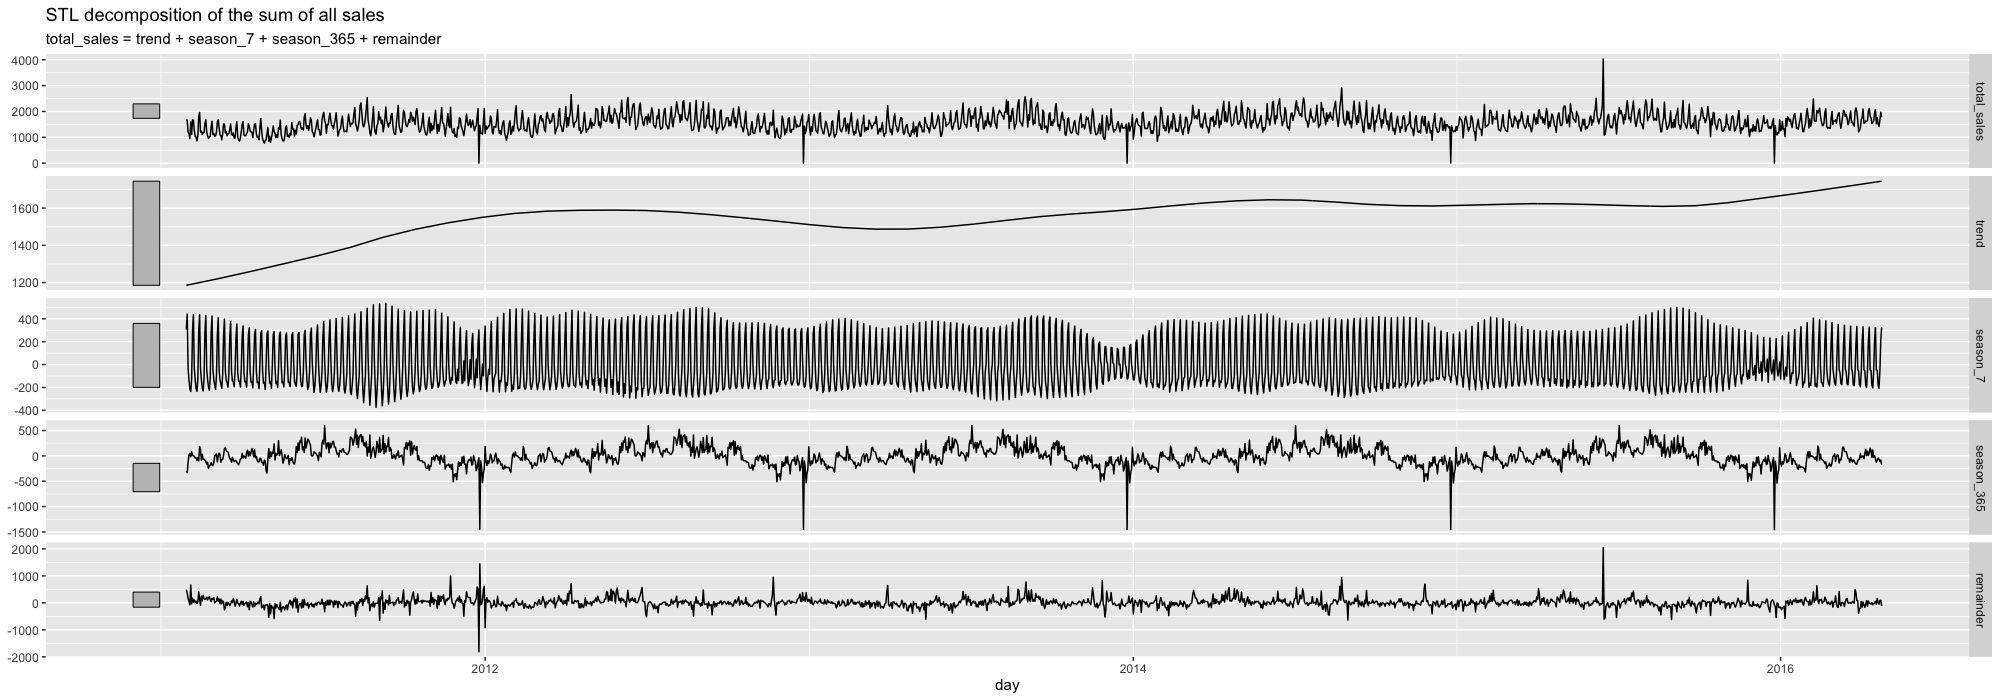

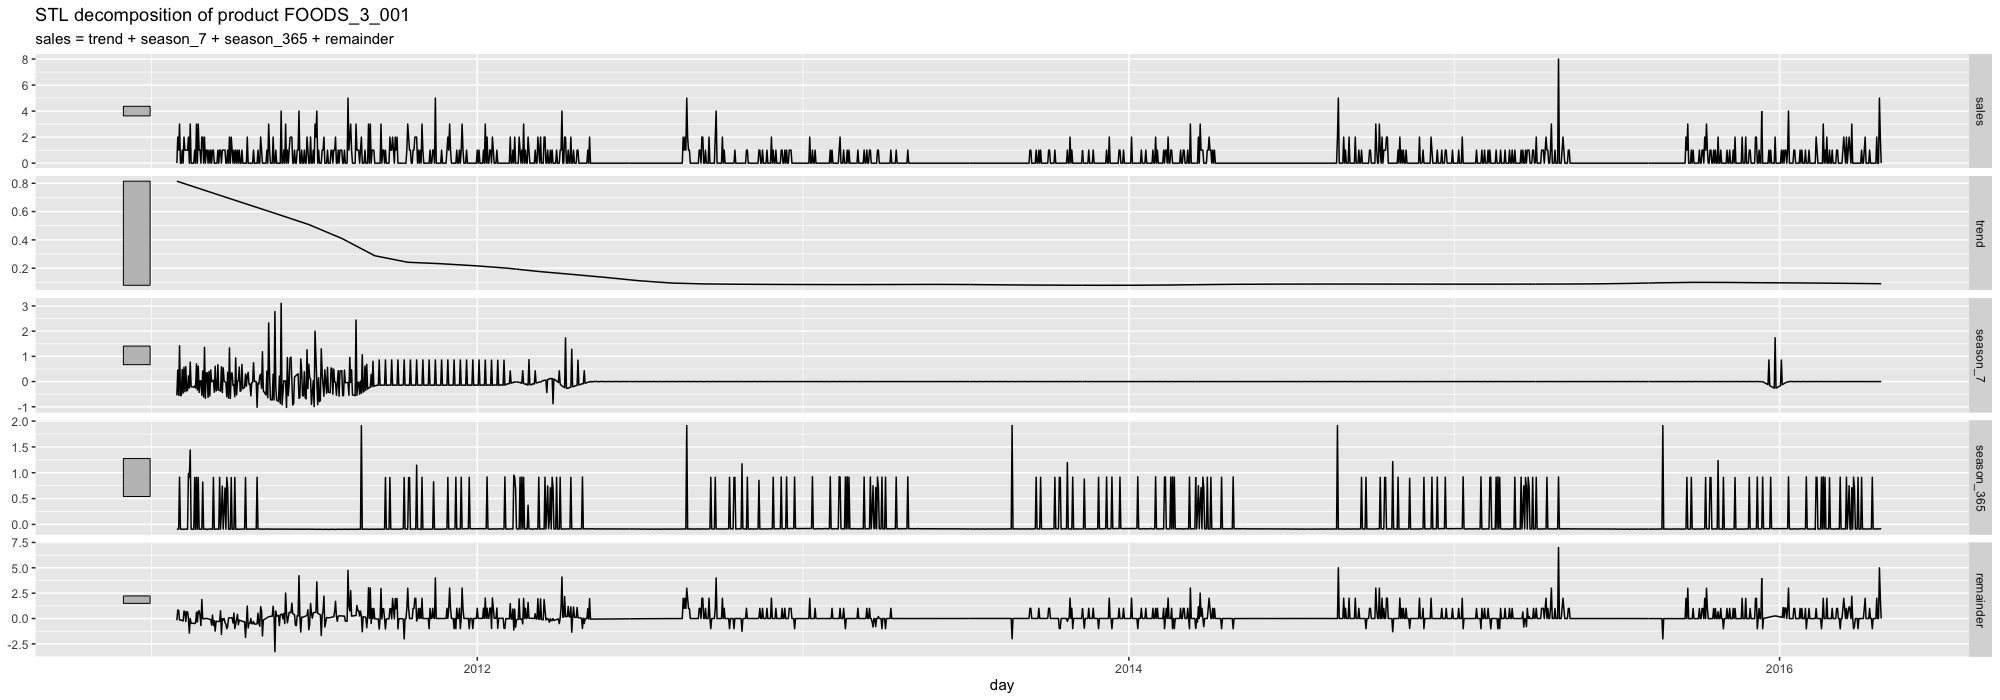

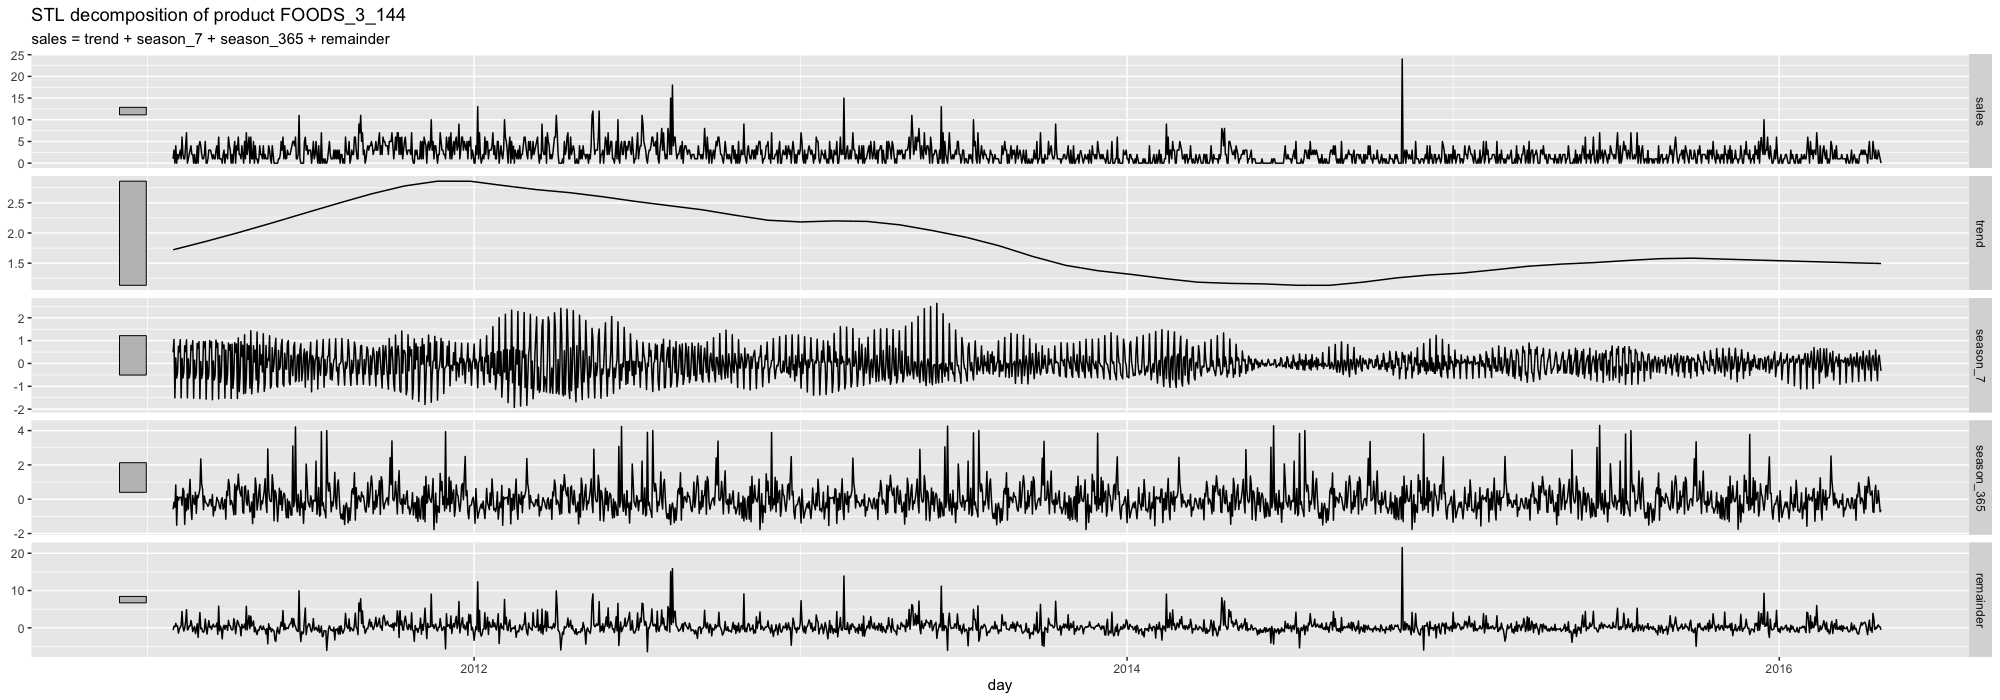

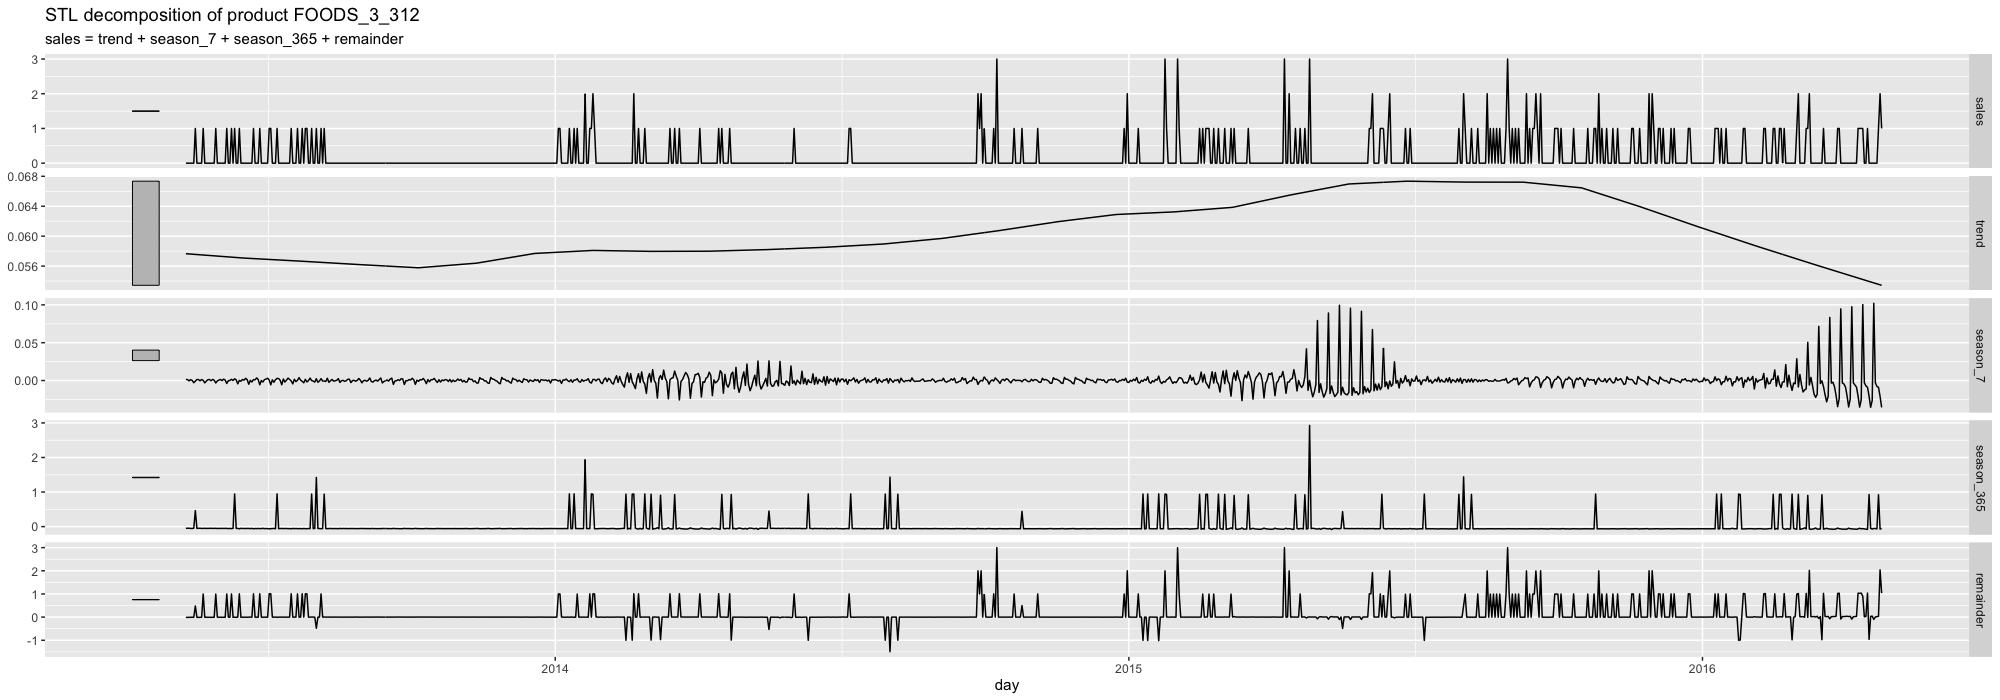

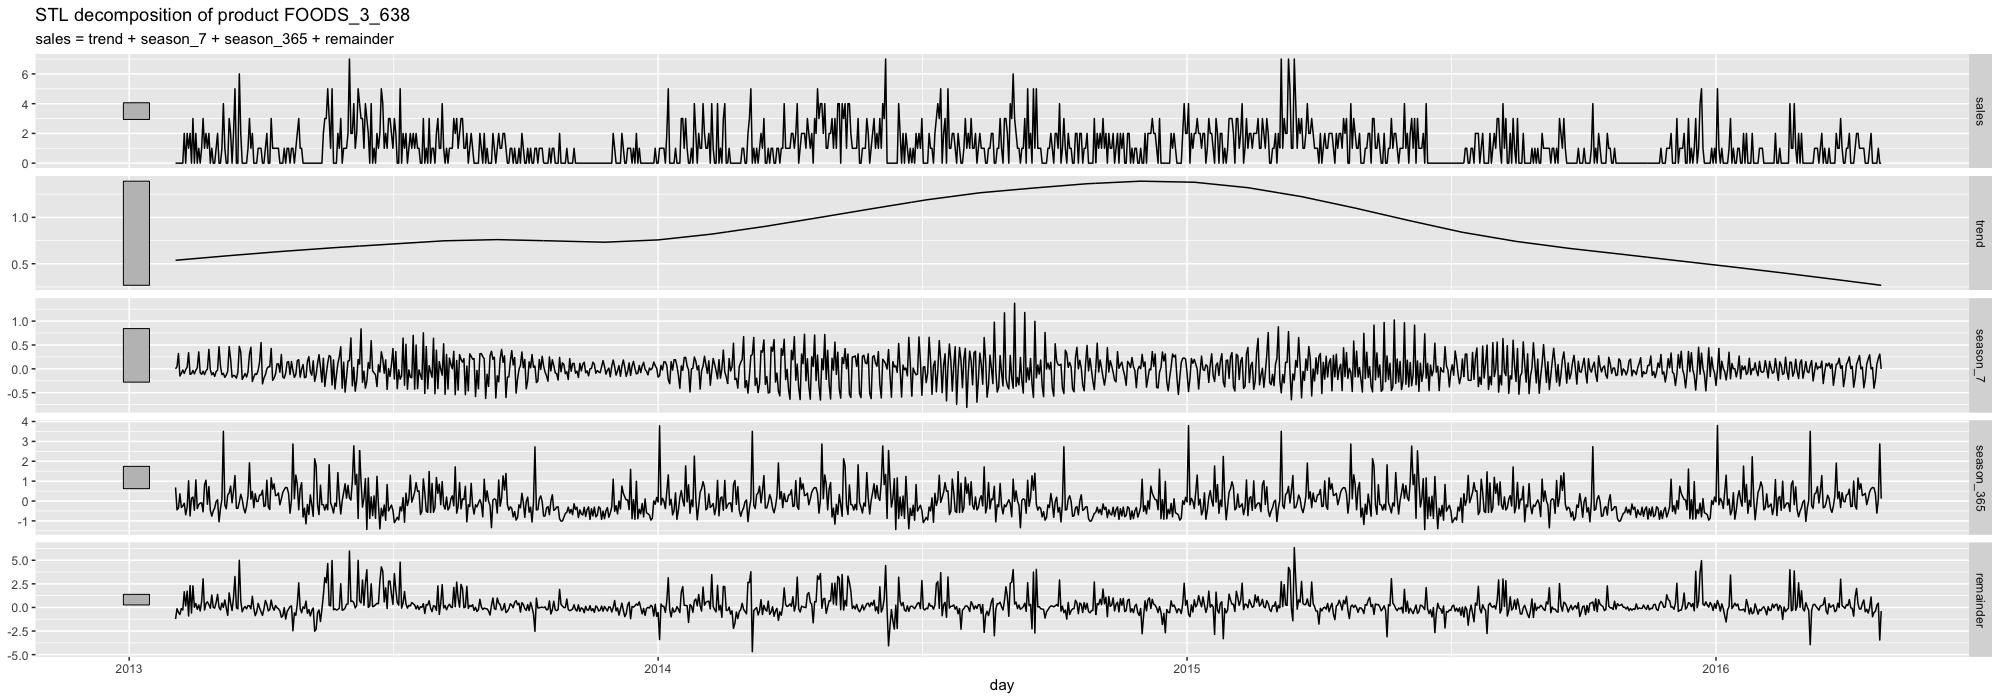

In [55]:
agg_sales |>
  model(
    STL(
      total_sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  ) |>
  components() |>
  autoplot() +
  labs(title = "STL decomposition of the sum of all sales")
train |>
  filter(product == "FOODS_3_001") |>
  model(
    STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  ) |>
  components() |>
  autoplot() +
  labs(title = "STL decomposition of product FOODS_3_001")
train |>
  filter(product == "FOODS_3_144") |>
  model(
    STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  ) |>
  components() |>
  autoplot() +
  labs(title = "STL decomposition of product FOODS_3_144")
train |>
  filter(product == "FOODS_3_312") |>
  model(
    STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  ) |>
  components() |>
  autoplot() +
  labs(title = "STL decomposition of product FOODS_3_312")
train |>
  filter(product == "FOODS_3_638") |>
  model(
    STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  ) |>
  components() |>
  autoplot() +
  labs(title = "STL decomposition of product FOODS_3_638")
# train |> filter(product == "FOODS_3_001") |> features(sales, feat_acf)
# train |>  features(sales, unitroot_ndiffs)
# train |>  features(sales, feat_acf)


In [6]:
stl_feats <- train |>
  group_by(product) |>
  features(
    sales,
    feat_stl,
    .model = STL(
      sales ~ trend(window = 365) +
        season(period = 7) +
        season(period = 365),
      robust = TRUE
    )
  )


intermittency_features <- function(y) {
  y <- as.numeric(y)
  y[is.na(y)] <- 0

  nz_idx <- which(y > 0)
  p_zero <- mean(y == 0)

  # Average inter-demand interval (ADI)
  adi <- if (length(nz_idx) <= 1) Inf else mean(diff(nz_idx))

  # Non-zero statistics
  y_nz <- y[y > 0]
  mean_nz <- if (length(y_nz) == 0) 0 else mean(y_nz)
  var_nz <- if (length(y_nz) <= 1) 0 else var(y_nz)

  cv2 <- if (mean_nz <= 0) Inf else var_nz / (mean_nz^2)

  tibble(
    p_zero = p_zero,
    adi = adi,
    mean_nz = mean_nz,
    cv2 = cv2
  )
}

feat_int <- train |>
  as_tibble() |>
  group_by(product) |>
  summarise(intermittency_features(sales), .groups = "drop")
head(feat_int)

average_sparsity <- mean(feat_int$p_zero)
cat("Average Sparsity (Proportion of zero daily sales across all products): ", round(average_sparsity, 4), "\n")

features_all <- feat_int |>
  left_join(stl_feats, by = "product")
head(features_all)


product,p_zero,adi,mean_nz,cv2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FOODS_3_001,0.7741767,4.431555,1.451389,0.3359118
FOODS_3_002,0.3569097,1.477966,2.362098,0.3810892
FOODS_3_003,0.6745690,3.033333,1.496689,0.3206685
FOODS_3_004,0.8800755,8.341270,1.275591,0.1919550
FOODS_3_005,0.5279665,2.117517,1.615725,0.3531852
FOODS_3_006,0.4919455,1.963325,1.700000,0.2944984


Average Sparsity (Proportion of zero daily sales across all products):  0.5357 


product,p_zero,adi,mean_nz,cv2,trend_strength,seasonal_strength_week,seasonal_peak_week,seasonal_trough_week,spikiness,linearity,curvature,stl_e_acf1,stl_e_acf10
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FOODS_3_001,0.7741767,4.431555,1.451389,0.3359118,0.3385451,0.2512303,4,1,3.146080e-07,-3.7419373,6.8125147,-0.2229109,0.1554345
FOODS_3_002,0.3569097,1.477966,2.362098,0.3810892,0.4726839,0.2655646,3,6,5.310856e-06,-9.6687985,-4.3278458,-0.1690863,0.1419990
FOODS_3_003,0.6745690,3.033333,1.496689,0.3206685,0.4975702,0.1981170,2,0,4.434609e-06,-5.6405401,2.3335161,-0.2042931,0.1236924
FOODS_3_004,0.8800755,8.341270,1.275591,0.1919550,0.2060235,0.2616451,4,2,1.676044e-07,-0.1870864,-0.5848789,-0.1648961,0.1622403
FOODS_3_005,0.5279665,2.117517,1.615725,0.3531852,0.4637524,0.2570067,1,5,2.749912e-07,-6.4994622,-3.2039131,-0.1697976,0.1499727
FOODS_3_006,0.4919455,1.963325,1.700000,0.2944984,0.2856656,0.1943429,2,5,2.767205e-06,5.6094803,1.3845855,-0.2171139,0.1741818


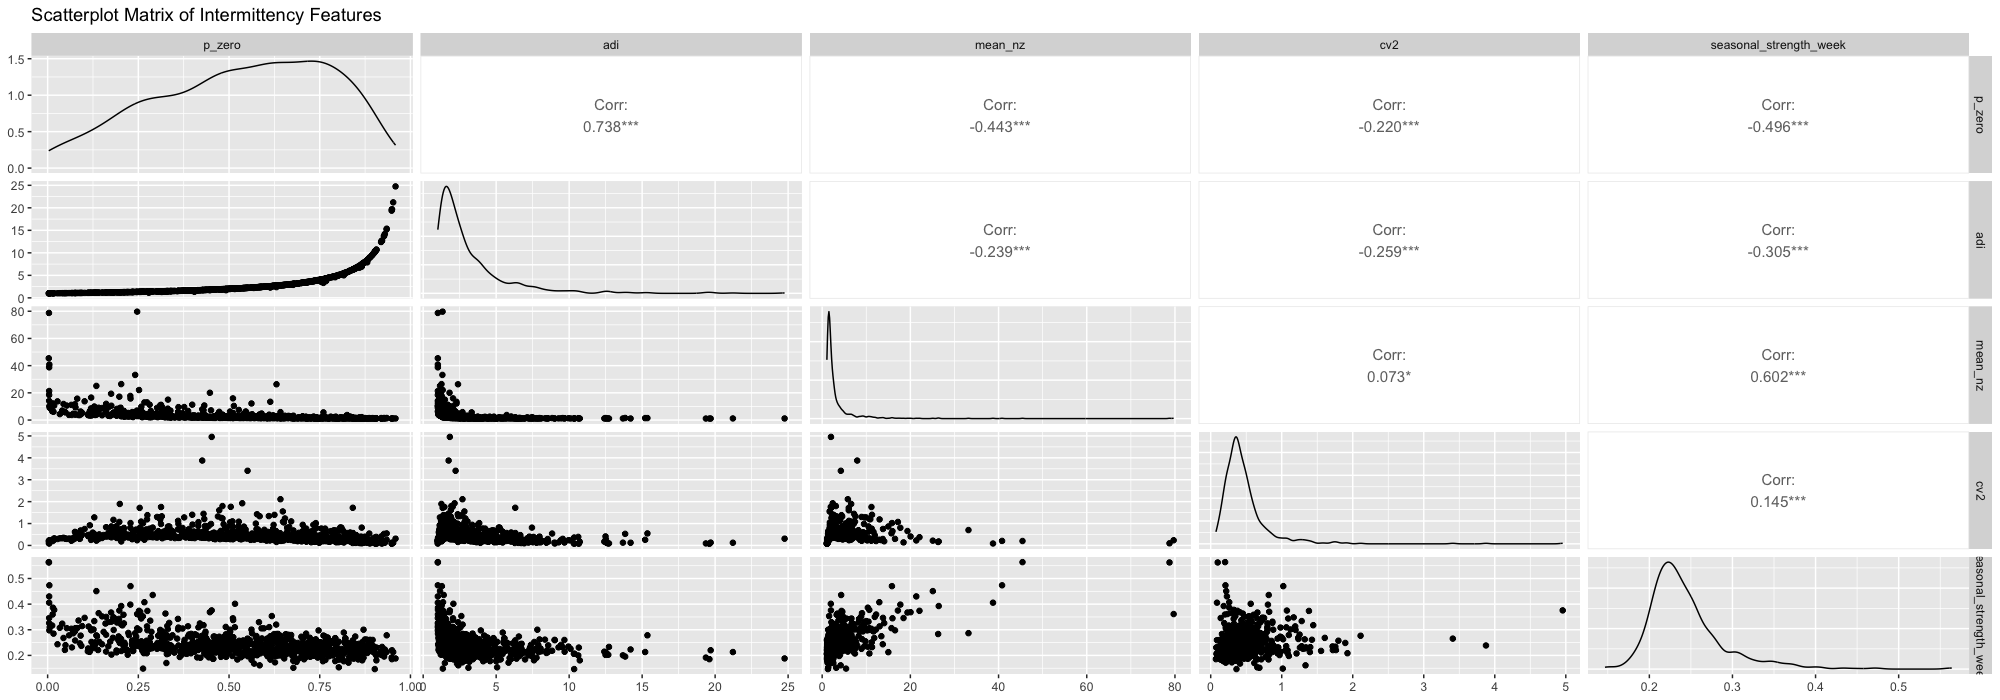

In [7]:
ggpairs(
  features_all,
  columns = c("p_zero", "adi", "mean_nz", "cv2", "seasonal_strength_week"),
  title = "Scatterplot Matrix of Intermittency Features"
)


In [8]:
feat <- features_all |>
  mutate(
    regime = if_else(p_zero > 0.6, "sparse", "dense")
  )


### Setting up some helper functions
We want to train the sparsity model ("hurdle model" or "occurrence model"), and then later a "size model" (how many sales given the fact that more than zero happen).

### Fit hurdle models on each product

In [9]:
# Settings
h <- 28 # forecast horizon / test window (days)

sparse_products <- feat |>
    filter(regime == "sparse") |>
    pull(product)

# Filter data to sparse products and split into train/test per product
data_sparse <- train |>
    filter(product %in% sparse_products) |>
    group_by(product) |>
    arrange(day, .by_group = TRUE) |>
    mutate(
        max_day = max(day),
        is_test = day > (max_day - days(h))
    ) |>
    ungroup() |>
    select(-max_day)

train_sparse <- data_sparse |> filter(!is_test)
test_sparse <- data_sparse |> filter(is_test)


# Nest by product for some reason
nested <- train_sparse |>
    group_by(product) |>
    nest()

# Fit models per product
models <- nested |>
    mutate(
        model = map(data, fit_hurdle_one)
    ) |>
    select(product, model)


Warning message:
“There were 368 warnings in `mutate()`.
The first warning was:
ℹ In argument: `model = map(data, fit_hurdle_one)`.
ℹ In group 1: `product = "FOODS_3_001"`.
Caused by warning:
! Unknown or uninitialised column: `product`.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 367 remaining warnings.”


### Predict and compute MSE on the test set

In [9]:
preds <- test_sparse |>
  as_tibble() |>
  group_by(product) |>
  tidyr::nest() |>
  left_join(models, by = "product") |>
  mutate(
    pred = purrr::map2(model, data, ~ predict_hurdle_one(.x, .y))
  ) |>
  select(product, pred) |>
  tidyr::unnest(pred)


# Evaluate RMSE per product and overall
rmse_by_product <- preds |>
  group_by(product) |>
  summarise(
    rmse = rmse(sales, y_hat),
    n_test = n(),
    .groups = "drop"
  )

overall_rmse <- rmse(preds$sales, preds$y_hat)
overall_mae <- mean(abs(preds$sales - preds$y_hat), na.rm = TRUE)

cat("RMSE on sparse products", overall_rmse, "\n")
cat("MAE on sparse products", overall_mae, "\n")
print(rmse_by_product |>
  arrange(desc(rmse)) |>
  head(20))


RMSE on sparse products 1.468172 
MAE on sparse products 0.6896336 
# A tibble: 20 × 3
   product      rmse n_test
   <chr>       <dbl>  <int>
 1 FOODS_3_008 17.4      28
 2 FOODS_3_444 10.8      28
 3 FOODS_3_441  5.29     28
 4 FOODS_3_557  4.17     28
 5 FOODS_3_059  3.97     28
 6 FOODS_3_147  3.69     28
 7 FOODS_3_813  3.43     28
 8 FOODS_3_187  2.82     28
 9 FOODS_3_643  2.81     28
10 FOODS_3_602  2.76     28
11 FOODS_3_148  2.57     28
12 FOODS_3_618  2.30     28
13 FOODS_3_249  2.24     28
14 FOODS_3_747  2.19     28
15 FOODS_3_422  2.16     28
16 FOODS_3_451  2.03     28
17 FOODS_3_020  2.03     28
18 FOODS_3_603  2.02     28
19 FOODS_3_317  1.97     28
20 FOODS_3_605  1.93     28
